In [158]:
# Environment and Core Libraries
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt

# PennyLane and PyTorch
import pennylane as qml
import torch
from torch.nn import Module, ParameterDict, Parameter
from torch.optim import Adam

# Lambeq
import discopy
from lambeq import BobcatParser, Rewriter, IQPAnsatz, SpacyTokeniser, AtomicType
from discopy.rigid import Ty
import spacy

# Patch for discopy
monoidal_module = getattr(discopy, "monoidal", None)
if monoidal_module:
    diagram_class = getattr(monoidal_module, "Diagram", None)
    if diagram_class and not hasattr(diagram_class, "is_mixed"):
        diagram_class.is_mixed = property(lambda self: False)

# Load spacy model
spacy.load('en_core_web_sm')

In [159]:
#Data Loading Function
def load_data(csv_file, sample_fraction=1.0):
    sentences1, sentences2, is_duplicate = [], [], []
    try:
        df = pd.read_csv(csv_file, encoding='utf-8')
        if sample_fraction < 1.0:
            df = df.sample(frac=sample_fraction, random_state=42).reset_index(drop=True)
        
        sentences1 = df['question1'].astype(str).tolist()
        sentences2 = df['question2'].astype(str).tolist()
        is_duplicate = df['is_duplicate'].tolist()
        
        print(f"Loaded {len(sentences1)} sentence pairs.")
        return sentences1, sentences2, is_duplicate
    except Exception as e:
        print(f"An error occurred: {e}")
        return [], [], []

In [ ]:
# QNLP MODEL AND TRAINING PIPELINE
# 1. THE QNLP MODEL CLASS
# ===============================================================
class QNLPModel(Module):
    def __init__(self, symbols):
        super().__init__()
        # Initialize parameters from a normal distribution with a small standard deviation
        self.params = ParameterDict()
        for s in symbols:
            self.params[s.name.replace('.', '_')] = Parameter(torch.randn(1) * 0.1)

    def initialise_weights(self):
        """Re-initialises the weights of the model."""
        for param in self.params.values():
            param.data.normal_(0, 0.1) # Modify tensor in-place

    def forward(self, diagram):
        param_values = [self.params[s.name.replace('.', '_')] for s in diagram.free_symbols]
        if not param_values:
            return torch.tensor([])
        return torch.cat(param_values)

# ===============================================================
# 2. HELPER FUNCTIONS
# ===============================================================
def FischerInformation(Fidelity):
    """Calculates the Fubini-Study distance from the fidelity."""
    rootFidelity = math.sqrt(abs(Fidelity))
    clamped_val = max(-1.0, min(1.0, rootFidelity))
    return math.acos(clamped_val)

def get_diagram_width(diagram):
    """Calculates the true maximum width of a diagram at any point."""
    if not diagram.boxes:
        return len(diagram.cod)
    # The width is the maximum wire index a box acts on.
    return max(
        [offset + len(box.dom) for box, offset in zip(diagram.boxes, diagram.offsets)]
        + [len(diagram.cod)]
    )

def execute_discopy_diagram(diagram, params, wires):
    """Executes a DisCoPy/lambeq diagram's instructions on a specific set of wires."""
    wire_map = {i: w for i, w in enumerate(wires)}
    param_idx = 0
    for gate, offset in zip(diagram.boxes, diagram.offsets):
        if hasattr(qml, gate.name):
            op = getattr(qml, gate.name)
            gate_params = []
            num_params = len(gate.free_symbols)
            if num_params > 0:
                gate_params = params[param_idx : param_idx + num_params]
                param_idx += num_params
            target_wires = [wire_map[i + offset] for i in range(len(gate.dom))]
            op(*gate_params, wires=target_wires)

# ===============================================================
# 3. PREPROCESSING FUNCTION
# ===============================================================
def preprocess_data_for_model(data_pairs, Tokeniser, ansatz, parser, rewriter, qubit_limit=20):
    print(f"Starting preprocessing with a qubit limit of {qubit_limit}...")
    filtered_pairs, all_symbols, n_max = [], set(), 0
    for s1, s2, is_duplicate in data_pairs:
        try:
            d1 = ansatz(rewriter(parser.sentence2diagram(Tokeniser.tokenise_sentence(s1), tokenised=True)))
            d2 = ansatz(rewriter(parser.sentence2diagram(Tokeniser.tokenise_sentence(s2), tokenised=True)))
            width1 = get_diagram_width(d1)
            width2 = get_diagram_width(d2)
            if width1 <= qubit_limit and width2 <= qubit_limit:
                pair_data = {
                    's1': s1, 's2': s2, 'label': is_duplicate, 'd1': d1, 'd2': d2,
                    'structural_disparity': abs(len(d1.cod) - len(d2.cod))
                }
                filtered_pairs.append(pair_data)
                all_symbols.update(d1.free_symbols)
                all_symbols.update(d2.free_symbols)
                n_max = max(n_max, width1, width2)
        except Exception:
            continue
    print(f"Preprocessing complete. Found {len(filtered_pairs)} valid pairs.")
    print(f"Total unique parameters (symbols) found: {len(all_symbols)}")
    print(f"N_Max for the filtered dataset is: {n_max}")
    return filtered_pairs, sorted(list(all_symbols), key=lambda s: s.name), n_max

# ===============================================================
# 4. THE TRAINING FUNCTION (with Fischer LR & Param Tracking)
# ===============================================================
def train_with_fischer_lr(data, symbols, n_max, base_learning_rate=0.01, lambda_penalty=0.1, epochs=10):
    model = QNLPModel(symbols)
    swap_dev = qml.device("lightning.qubit", wires=1 + 2 * n_max)

    loss_history = []
    param_history = []
    print("--- Starting training with CUSTOM Fischer Information LR ---")

    for epoch in range(epochs):
        total_loss_epoch = 0
        num_trained_pairs = 0
        for i, pair in enumerate(data):
            params1_torch, params2_torch = model(pair['d1']), model(pair['d2'])
            if params1_torch.nelement() == 0 or params2_torch.nelement() == 0:
                continue
            num_trained_pairs += 1

            # Define a pure cost function that PennyLane can differentiate
            def cost_fn(p1_np, p2_np, get_overlap=False):
                @qml.qnode(swap_dev)
                def swap_test_qnode(p1, p2):
                    qml.Hadamard(wires=0)
                    execute_discopy_diagram(pair['d1'], p1, wires=range(1, 1 + n_max))
                    execute_discopy_diagram(pair['d2'], p2, wires=range(1 + n_max, 1 + 2 * n_max))
                    for i in range(n_max):
                        qml.CSWAP(wires=[0, 1 + i, 1 + n_max + i])
                    qml.Hadamard(wires=0)
                    return qml.expval(qml.PauliZ(0))
                
                measured_overlap = swap_test_qnode(p1_np, p2_np)
                
                if get_overlap:
                    return measured_overlap

                fidelity_loss = (measured_overlap - pair['label'])**2
                structural_penalty = lambda_penalty * pair['structural_disparity']
                return fidelity_loss + structural_penalty

            params1_np = params1_torch.detach().numpy()
            params2_np = params2_torch.detach().numpy()
            
            # Get gradients and loss
            grad_fn = qml.grad(cost_fn, argnum=[0, 1])
            grads_np_tuple = grad_fn(params1_np, params2_np)
            loss_val = cost_fn(params1_np, params2_np)
            total_loss_epoch += loss_val

            # Get overlap for Fischer Information calculation
            measured_overlap_val = cost_fn(params1_np, params2_np, get_overlap=True)
            
            # Calculate dynamic learning rate
            qangle = FischerInformation(measured_overlap_val)
            normalized_qangle = qangle / (math.pi / 2)
            eta_dynamic = base_learning_rate * normalized_qangle if pair['label'] == 1 else base_learning_rate * (1 - normalized_qangle)

            # Manually update the model's parameters
            with torch.no_grad():
                grad_dict = {}
                param_idx = 0
                for sym in pair['d1'].free_symbols:
                    sanitized_name = sym.name.replace('.', '_')
                    grad_dict[sanitized_name] = grads_np_tuple[0][param_idx] # pyright: ignore[reportGeneralTypeIssues]
                    param_idx += 1
                
                param_idx = 0
                for sym in pair['d2'].free_symbols:
                    sanitized_name = sym.name.replace('.', '_')
                    if sanitized_name in grad_dict:
                        grad_dict[sanitized_name] += grads_np_tuple[1][param_idx] # pyright: ignore[reportGeneralTypeIssues]
                    else:
                        grad_dict[sanitized_name] = grads_np_tuple[1][param_idx] # pyright: ignore[reportGeneralTypeIssues]
                    param_idx += 1

                for name, param in model.named_parameters():
                    if name in grad_dict:
                        param.data.add_(-eta_dynamic * torch.tensor(grad_dict[name]))
        
        # Track parameter statistics at the end of each epoch
        all_params = torch.cat([p.data.flatten() for p in model.parameters()]).numpy()
        param_history.append({
            'mean': np.mean(all_params), 'std': np.std(all_params),
            'min': np.min(all_params), 'max': np.max(all_params)
        })

        avg_loss = total_loss_epoch / num_trained_pairs if num_trained_pairs > 0 else 0
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Average Penalized Loss: {avg_loss:.4f}")
        
    return model, loss_history, param_history

In [161]:
#Legacy methods for reference
def loss_function_manual(overlap, target_fidelity, structural_disparity, lambda_penalty):
    """
    Classical loss function used by the manual gradient calculator.
    """
    fidelity_loss = (target_fidelity - overlap)**2
    structural_penalty = lambda_penalty * structural_disparity
    return fidelity_loss + structural_penalty

def calculate_overlap_classical(qnode_func, params1, params2):
    """
    Calculates overlap on a statevector simulator (classical shortcut).
    """
    state1 = qnode_func(params1)
    state2 = qnode_func(params2)
    return np.abs(np.vdot(state1, state2))**2

def calculate_pair_gradients(qnode_func, params, s1, s2, target_fidelity, structural_disparity, lambda_penalty):
    """
    Calculates gradients for a pair of sentences using the parameter-shift rule.
    """
    gradients = {idx: 0.0 for idx in [(g, e) for g in range(len(params)) for e in range(len(params[g]))]}

    for group_idx, group in enumerate(params):
        for elem_idx in range(len(group)):
            param_index = (group_idx, elem_idx)

            # Shift the parameters
            params_plus = [p.copy() for p in params]
            params_plus[group_idx][elem_idx] += np.pi / 2
            
            params_minus = [p.copy() for p in params]
            params_minus[group_idx][elem_idx] -= np.pi / 2

            # Calculate overlap for shifted parameters
            # Note: This is a simplified gradient of a complex function. 
            # In a real scenario, the gradient of the loss with respect to
            # both state preparations would need to be calculated.
            overlap_plus = calculate_overlap_classical(qnode_func, params_plus, params_plus)
            overlap_minus = calculate_overlap_classical(qnode_func, params_minus, params_minus)

            loss_plus = loss_function_manual(overlap_plus, target_fidelity, structural_disparity, lambda_penalty)
            loss_minus = loss_function_manual(overlap_minus, target_fidelity, structural_disparity, lambda_penalty)
            
            # The parameter-shift rule
            grad = (loss_plus - loss_minus) / 2
            gradients[param_index] = grad

    return gradients

In [ ]:
#Legacy methods for reference
def swap_test(state1_vec, state2_vec, num_qubits):
    """
    Performs a Quantum Swap Test between two quantum state vectors by sampling.
    """
    SHOT_COUNT = 100000  # High shot count for better statistical accuracy
    
    total_qubits = 1 + 2 * num_qubits  # 1 Ancilla qubit + 2 state registers
    dev = qml.device("default.qubit", wires=total_qubits, shots=SHOT_COUNT)

    @qml.qnode(dev)
    def circuit():
        # Step 1: Prepare the ancilla qubit in a superposition
        qml.Hadamard(wires=0)
        
        # Step 2: Prepare the two input states
        qml.StatePrep(state1_vec, wires=range(1, 1 + num_qubits))
        qml.StatePrep(state2_vec, wires=range(1 + num_qubits, 1 + 2 * num_qubits))

        # Step 3: Apply controlled-SWAP gates
        for i in range(num_qubits):
            qml.CSWAP(wires=[0, 1 + i, 1 + num_qubits + i])

        # Step 4: Apply Hadamard to the ancilla
        qml.Hadamard(wires=0)
        
        # Step 5: Measure the ancilla qubit
        return qml.sample(wires=0)

    # The squared overlap is related to the probability of measuring |0>
    # P(0) = (1 + |<psi|phi>|^2) / 2
    # Overlap^2 = 2 * P(0) - 1
    measurement_results = circuit()
    prob_0 = np.sum(measurement_results == 0) / SHOT_COUNT
    squared_overlap = 2 * prob_0 - 1
    
    return abs(squared_overlap)

In [171]:
#Plotting function
def plot_training_history(history):
    if not history:
        print("History is empty. Cannot plot.")
        return

    plt.figure(figsize=(10, 6))
    plt.plot(history, label='Average Loss per Epoch')
    plt.title('Training Loss Convergence')
    plt.xlabel('Epoch')
    plt.ylabel('Average Penalized Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
def plot_parameter_history(param_history):
    if not param_history:
        print("Parameter history is empty. Cannot plot.")
        return

    epochs = range(len(param_history))
    means = [d['mean'] for d in param_history]
    stds = [d['std'] for d in param_history]
    mins = [d['min'] for d in param_history]
    maxs = [d['max'] for d in param_history]

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, means, label='Mean Parameter Value')
    plt.fill_between(epochs, np.array(means) - np.array(stds), np.array(means) + np.array(stds), alpha=0.2, label='1 Std. Deviation')
    plt.plot(epochs, mins, linestyle='--', color='gray', label='Min/Max Range')
    plt.plot(epochs, maxs, linestyle='--', color='gray')
    
    plt.title('Evolution of Model Parameters During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Parameter Value')
    plt.legend()
    plt.grid(True)
    plt.show()
def plot_parameter_evolution_polar(param_history):
    if not param_history:
        print("Parameter history is empty. Cannot plot.")
        return
    # Use a slightly larger figure for polar plots
    plt.figure(figsize=(8, 8))
    
    # Create a polar subplot
    ax = plt.subplot(111, projection='polar')

    epochs = np.array(range(len(param_history)))
    # We use modulo 2*pi to keep the angles in one circle
    mean_angles = np.array([d['mean'] for d in param_history]) % (2 * np.pi)

    # The radius will be the epoch number, so the path spirals outwards over time
    # The angle will be the mean parameter value
    ax.plot(mean_angles, epochs, 'o-', label='Mean Parameter Path')

    # Add markers for the start and end points for clarity
    if len(epochs) > 0:
        ax.plot(mean_angles[0], epochs[0], 'gX', markersize=12, label='Start')
        ax.plot(mean_angles[-1], epochs[-1], 'rX', markersize=12, label='End')

    # Formatting the plot
    ax.set_theta_zero_location('N') # pyright: ignore[reportAttributeAccessIssue] # Set 0 degrees to the top
    ax.set_theta_direction(-1) # pyright: ignore[reportAttributeAccessIssue] # Make it clockwise
    ax.set_rlabel_position(0) # pyright: ignore[reportAttributeAccessIssue]
    ax.set_rlim(0, len(epochs) * 1.05) # pyright: ignore[reportAttributeAccessIssue] # Set radius limit
    ax.set_xlabel("Epoch") # The radius represents the epoch
    ax.set_title('Cyclical Evolution of Mean Parameter', pad=20)
    ax.legend()
    plt.show()
def plot_parameter_deltas(param_history):
    if len(param_history) < 2:
        print("Need at least 2 epochs to plot parameter deltas.")
        return

    mean_angles = np.array([d['mean'] for d in param_history])
    
    # Calculate the shortest angle difference between each epoch
    deltas = []
    for i in range(1, len(mean_angles)):
        prev_angle = mean_angles[i-1]
        curr_angle = mean_angles[i]
        delta = np.arctan2(np.sin(curr_angle - prev_angle), np.cos(curr_angle - prev_angle))
        deltas.append(delta)

    plt.figure(figsize=(10, 6))
    # We plot against epochs 1 to N, since the first delta occurs at epoch 1
    plt.plot(range(1, len(mean_angles)), deltas, 'o-', label='Change in Mean Parameter (Delta)')
    
    plt.axhline(0, color='red', linestyle='--', label='No Change')
    plt.title('Epoch-to-Epoch Change in Mean Parameter Value')
    plt.xlabel('Epoch')
    plt.ylabel('Shortest Angle Difference (Radians)')
    plt.legend()
    plt.grid(True)
    plt.xticks(range(1, len(mean_angles)))
    plt.show()

In [ ]:
#  HYPERPARAMETERS AND CONFIGURATION
# ===============================================================

# --- Data and Preprocessing ---
DATA_PATH = r'<ABSOLUTE_PATH_TO_YOUR_QUESTIONS.CSV>'
SAMPLE_FRACTION = 0.001  # Fraction of the dataset to use for a quick run
QUBIT_LIMIT = 12         # Max qubits for a diagram to be included (adjust based on RAM)

# --- Model and Circuit ---
# Define the mapping from grammatical types to qubits
N = AtomicType.NOUN
S = AtomicType.SENTENCE
OB_MAP: dict[Ty, int] = { N: 1, S: 1 } # pyright: ignore[reportAssignmentType]

# Define the ansatz
N_LAYERS = 1
ANSATZ = IQPAnsatz(OB_MAP, n_layers=N_LAYERS) # pyright: ignore[reportArgumentType]

# Define the rewrite rules
REWRITE_RULES = ['curry', 'prepositional_phrase', 'determiner']

# --- Training ---
EPOCHS = 15
BASE_LEARNING_RATE = 0.01
LAMBDA_PENALTY = 0.1

Loaded 404 sentence pairs.
Starting preprocessing with a qubit limit of 12...
Preprocessing complete. Found 13 valid pairs.
Total unique parameters (symbols) found: 155
N_Max for the filtered dataset is: 11
--- Starting training with CUSTOM Fischer Information LR ---


c:\Users\Jash\Documents\Research\Semantic Equivilance\.venv\Lib\site-packages\autograd\tracer.py:16: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Epoch 1/15, Average Penalized Loss: 0.2801
Epoch 2/15, Average Penalized Loss: 0.2801
Epoch 3/15, Average Penalized Loss: 0.2801
Epoch 4/15, Average Penalized Loss: 0.2801
Epoch 5/15, Average Penalized Loss: 0.2801
Epoch 6/15, Average Penalized Loss: 0.2801
Epoch 7/15, Average Penalized Loss: 0.2801
Epoch 8/15, Average Penalized Loss: 0.2801
Epoch 9/15, Average Penalized Loss: 0.2801
Epoch 10/15, Average Penalized Loss: 0.2801
Epoch 11/15, Average Penalized Loss: 0.2801
Epoch 12/15, Average Penalized Loss: 0.2801
Epoch 13/15, Average Penalized Loss: 0.2801
Epoch 14/15, Average Penalized Loss: 0.2801
Epoch 15/15, Average Penalized Loss: 0.2801

--- Training Results ---


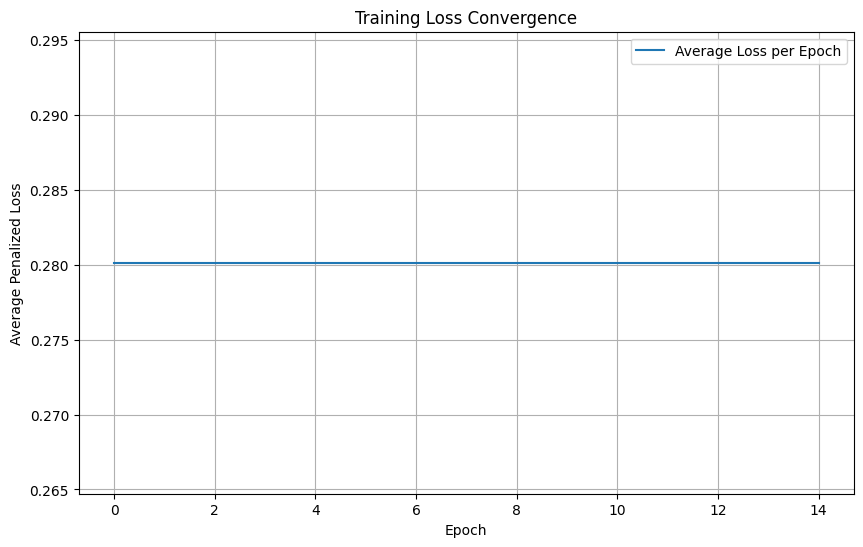

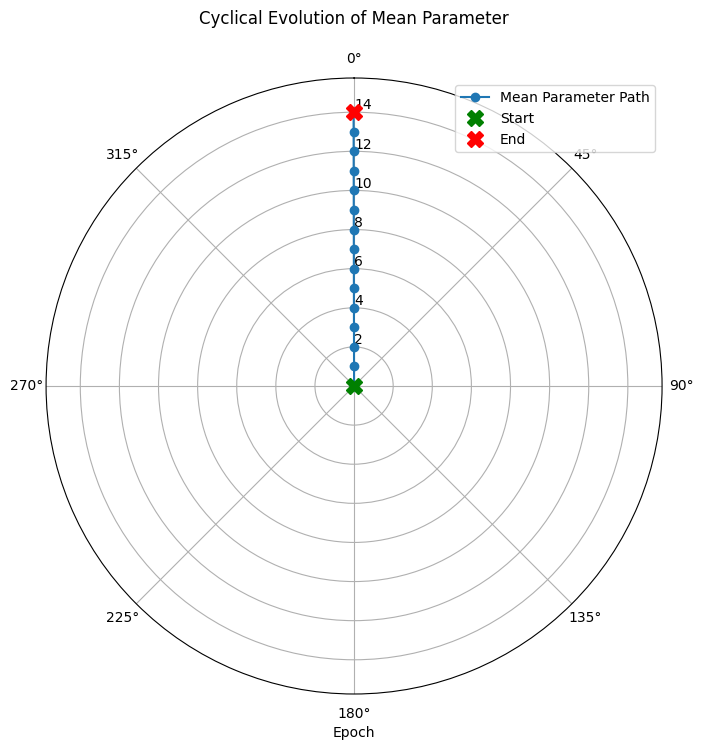

In [ ]:
#Click this to run model
# 1. Initialize lambeq components using the defined hyperparameters
tokeniser = SpacyTokeniser()
parser = BobcatParser()
rewriter = Rewriter(REWRITE_RULES)

# 2. Load and preprocess data
sentences1, sentences2, value = load_data(DATA_PATH, sample_fraction=SAMPLE_FRACTION)
data_pairs = list(zip(sentences1, sentences2, value))

filtered_data, symbols, n_max = preprocess_data_for_model(
    data_pairs, tokeniser, ANSATZ, parser, rewriter, qubit_limit=QUBIT_LIMIT
)

# 3. Run training and plot results
if filtered_data and n_max > 0:
    # Call the new training function
    trained_model, loss_history, param_history = train_with_fischer_lr(
        filtered_data, 
        symbols, 
        n_max, 
        epochs=EPOCHS
    )
    
    # Create both plots
    print("\n--- Training Results ---")
    plot_training_history(loss_history)
    plot_parameter_evolution_polar(param_history)
    plot_parameter_deltas(param_history)
else:
    print("\nNo data to train on.")